# Notebook 1 — Implied Risk‑Neutral Distribution from Call Prices

This notebook computes the **risk‑neutral probability distribution** of the terminal price \(S_T\) from a single day’s option chain using the Breeden–Litzenberger idea:
  
- \(C(K) = D\,\mathbb{E}[(S_T - K)^+]\)  ⇒  \(-\partial C/\partial K = D\,\mathbb{Q}(S_T > K)\)  ⇒  \(\partial^2 C/\partial K^2 = D\,f_{S_T}(K)\).  
- We recover the **PDF** as \(f_{S_T}(K) = D^{-1} C''(K)\), after cleaning the call curve so it is **decreasing** and **convex** in strike \(K\).

### What you’ll see
1. **Data ingest:** fetch a single expiry via `yfinance` (or use the included `sample_chain.csv` if offline).
2. **Forward & discount:** infer \(F_T\) and \(D=e^{-rT}\) from put–call parity with a robust linear fit.
3. **No‑arbitrage cleaning:** project call prices onto the cone {decreasing & convex in \(K\)} to remove butterfly arbitrage.
4. **Implied CDF/PDF:** compute first/second strike derivatives, clip tiny negatives, renormalize, and verify moments.
5. **Plots & diagnostics:** raw vs cleaned calls, tail probability, PDF vs a matched lognormal, and a small metrics table.

> **Tip:** Run this notebook end‑to‑end on a single expiry for **SPY** to keep data small and compute instantaneous.


## 0) Setup & dependencies

This notebook needs a few common packages. If something is missing on your machine, uncomment the `pip install` cell below.


In [ ]:
# If needed, uncomment and run:
# %pip install yfinance numpy pandas scipy matplotlib cvxpy nbformat


In [2]:
import numpy as np
import pandas as pd
import math, warnings
import matplotlib.pyplot as plt

# Optional: live fetch (will be skipped if offline)
try:
    import yfinance as yf
    HAVE_YF = True
except Exception:
    HAVE_YF = False

# Optimizers
import numpy.linalg as LA
from scipy import optimize, signal, stats

# Try cvxpy for clean convex-monotone projection; fall back to SciPy if unavailable
try:
    import cvxpy as cp
    HAVE_CVXPY = True
except Exception:
    HAVE_CVXPY = False

pd.set_option('display.float_format', lambda v: f'{v:,.6f}')
warnings.filterwarnings('ignore')


## 1) Configuration (ticker & expiry)

Set your **ticker** and **expiry**. If live fetch fails (e.g., no internet), the notebook will fall back to the **sample CSV** bundled with this project.


In [3]:
# --- User-set inputs ---
TICKER = "SPY"                 # e.g., "SPY" or "AAPL"
EXPIRY = None                  # e.g., "2025-10-17" (YYYY-MM-DD). If None, we pick the first available.
SAMPLE_CSV = r"/mnt/data/sample_chain.csv"  # offline sample fallback

# Strike range to keep (relative to forward); helps reduce edge noise
KEEP_FWD_MULT = (0.5, 1.5)

# Savitzky–Golay smoothing window for the cleaned call curve prior to differencing
SG_WINDOW = 9   # must be odd and <= number of points
SG_POLY   = 3


## 2) Data ingest (live via `yfinance`, else offline sample)

We try to:
- Pull the option chain for a **single expiry**.
- Compute **mid quotes** for calls (and puts if available).
- Restrict to a strike band around the forward to reduce edge artifacts.


In [4]:
def fetch_chain_yf(ticker:str, expiry:str|None):
    """Fetch a single expiry chain (calls & puts if available) via yfinance.
    Returns a DataFrame with columns: K, call_mid, put_mid (optional), and metadata.
    """
    if not HAVE_YF:
        return None
    try:
        tk = yf.Ticker(ticker)
        exps = tk.options
        if not exps:
            return None
        exp = expiry or exps[0]
        opt = tk.option_chain(exp)
        calls = opt.calls.copy()
        puts  = opt.puts.copy() if opt.puts is not None else None

        # Mid prices
        calls['call_mid'] = (calls['bid'].fillna(0) + calls['ask'].fillna(0))/2
        # Some tickers have NaNs; drop if entirely missing
        calls = calls[['strike','call_mid','bid','ask','impliedVolatility','openInterest']].rename(
            columns={'strike':'K','impliedVolatility':'iv','openInterest':'oi','bid':'call_bid','ask':'call_ask'}
        )
        if puts is not None and len(puts):
            puts['put_mid'] = (puts['bid'].fillna(0) + puts['ask'].fillna(0))/2
            puts = puts[['strike','put_mid']].rename(columns={'strike':'K'})
            df = pd.merge(calls, puts, on='K', how='left')
        else:
            df = calls
        df['expiry'] = pd.to_datetime(exp).date().isoformat()
        return df.sort_values('K').reset_index(drop=True)
    except Exception as e:
        return None

def load_sample_csv(path:str):
    df = pd.read_csv(path)
    # keep only necessary columns if present
    keep = [c for c in ['K','call_mid','put_mid','call_bid','call_ask','expiry'] if c in df.columns]
    df = df[keep].copy()
    return df.sort_values('K').reset_index(drop=True)

# Try live, else sample
df_raw = fetch_chain_yf(TICKER, EXPIRY)
source = "yfinance"
if df_raw is None or len(df_raw)==0 or df_raw['call_mid'].fillna(0).sum()==0:
    df_raw = load_sample_csv(SAMPLE_CSV)
    source = "sample_csv"

print(f"Data source: {source}; rows: {len(df_raw)}")
df_raw.head(10)


Data source: yfinance; rows: 69


,K,call_mid,call_bid,call_ask,iv,oi,put_mid,expiry
0,566.000000,86.560000,85.150000,87.970000,1.591311,30,0.005000,2025-09-10
1,570.000000,82.605000,81.280000,83.930000,1.540041,2,0.005000,2025-09-10
2,576.000000,75.790000,74.800000,76.780000,1.077153,1,0.005000,2025-09-10
3,580.000000,72.045000,71.540000,72.550000,1.176762,66,0.005000,2025-09-10
4,587.000000,65.385000,65.320000,65.450000,1.197758,1,0.005000,2025-09-10
5,595.000000,57.435000,57.390000,57.480000,1.084966,2,0.005000,2025-09-10
6,600.000000,52.390000,52.310000,52.470000,0.992188,27,0.005000,2025-09-10
7,605.000000,47.385000,47.290000,47.480000,0.911134,6,0.005000,2025-09-10
8,608.000000,44.440000,44.390000,44.490000,0.875978,5,0.005000,2025-09-10
9,610.000000,42.455000,42.290000,42.620000,0.846681,13,0.005000,2025-09-10


## 3) Infer forward \(F_T\) and discount \(D=e^{-rT}\) via put–call parity

At a fixed expiry \(T\), for each strike \(K\):
\[
C(K) - P(K) \;=\; D\,(F_T - K).
\]
Thus a **robust linear regression** of \(Y=C-P\) against \(X=K\) gives:
- slope \(\hat\beta_1 \approx -D\)
- intercept \(\hat\beta_0 \approx D\,F_T\)  
⇒ \(\hat D=-\hat\beta_1,\ \ \hat F_T=\hat\beta_0/\hat D\).

If puts are missing, we fall back to **short‑dated** assumption \(D\approx 1\) and set \(F_T\) from spot (if available) or the strike minimizing call moneyness.


In [5]:
def infer_forward_discount(df: pd.DataFrame):
    df = df.copy()
    have_puts = 'put_mid' in df.columns and df['put_mid'].notna().sum() > 5
    if have_puts:
        mask = df['call_mid'].notna() & df['put_mid'].notna()
        y = (df.loc[mask, 'call_mid'] - df.loc[mask, 'put_mid']).values
        X = df.loc[mask, 'K'].values
        # Linear regression y = a + b*K
        A = np.vstack([np.ones_like(X), X]).T
        sol, *_ = LA.lstsq(A, y, rcond=None)
        a, b = sol[0], sol[1]
        D = max(1e-6, -b)  # enforce non-negative discount
        F = a / D if D > 0 else np.nan
    else:
        # Fallback: D≈1; F≈argmin |call moneyness| via rough heuristic
        D = 1.0
        # If we had spot we'd prefer parity; here use the strike where call-mid ≈ intrinsic slope change
        idx = np.nanargmin(np.abs(np.diff(df['call_mid'], prepend=df['call_mid'].iloc[0])))
        F = df['K'].iloc[int(np.clip(idx, 0, len(df)-1))]
    return float(F), float(D)

F_T, D = infer_forward_discount(df_raw)
print(f"Inferred forward F_T = {F_T:,.4f}, discount D = {D:,.6f}")


Inferred forward F_T = 652.4199, discount D = 0.998628


## 4) Restrict to a forward-centered strike band and resample to a **uniform** grid

We keep strikes in \([\alpha F_T, \beta F_T]\) to reduce edge noise, then interpolate call mids to a uniform grid (central differences behave better on uniform spacing).

In [6]:
def restrict_and_uniformize(df: pd.DataFrame, F_T: float, keep_mult=(0.5,1.5), n_points=121):
    lo, hi = keep_mult
    kmin, kmax = F_T*lo, F_T*hi
    d = df[(df['K']>=kmin) & (df['K']<=kmax)].copy()
    d = d.dropna(subset=['call_mid'])
    if len(d) < 15:
        # if too few, widen bounds slightly
        d = df.copy().dropna(subset=['call_mid'])
    K_uni = np.linspace(d['K'].min(), d['K'].max(), n_points)
    C_interp = np.interp(K_uni, d['K'].values, d['call_mid'].values)
    # Optional: carry along put_mid if present (for later diagnostics only)
    df_uni = pd.DataFrame({'K':K_uni, 'call_mid':C_interp})
    if 'put_mid' in d.columns:
        P_interp = np.interp(K_uni, d['K'].values, d['put_mid'].values)
        df_uni['put_mid'] = P_interp
    return df_uni

df_uni = restrict_and_uniformize(df_raw, F_T, keep_mult=KEEP_FWD_MULT, n_points=181)
print(f"Uniform grid size: {len(df_uni)} (K from {df_uni['K'].min():.2f} to {df_uni['K'].max():.2f})")
df_uni.head()


Uniform grid size: 181 (K from 566.00 to 710.00)


,K,call_mid,put_mid
0,566.000000,86.560000,0.005000
1,566.800000,85.769000,0.005000
2,567.600000,84.978000,0.005000
3,568.400000,84.187000,0.005000
4,569.200000,83.396000,0.005000


## 5) No‑arbitrage cleaning in strike: decreasing & convex

For a fixed \(T\), the call price as a function of strike \(C(K)\) must satisfy:
- **Monotone:** \(C_{i+1}-C_i \le 0\) (decreasing in \(K\)).
- **Convex:** \(C_{i+1}-2C_i+C_{i-1} \ge 0\) (on a uniform grid).

We project the raw vector \(\mathbf{c}\) onto this **convex‑decreasing cone** by solving the small QP:
\[
\min_{\hat{\mathbf{c}}}\ \|\hat{\mathbf{c}}-\mathbf{c}\|_2^2
\quad \text{s.t.}\quad
D_1\,\hat{\mathbf{c}} \le 0,\ \ D_2\,\hat{\mathbf{c}}\ge 0,
\]
where \(D_1\) and \(D_2\) are first and second‑difference matrices.


In [7]:
def diff_matrices(n:int):
    # First difference matrix (n-1 x n)
    D1 = np.zeros((n-1, n))
    for i in range(n-1):
        D1[i, i]   = -1.0
        D1[i, i+1] =  1.0
    # Second difference matrix (n-2 x n)
    D2 = np.zeros((n-2, n))
    for i in range(n-2):
        D2[i, i]   =  1.0
        D2[i, i+1] = -2.0
        D2[i, i+2] =  1.0
    return D1, D2

def convex_monotone_fit(call_mid: np.ndarray):
    """Project call_mid onto the cone {D1*c <= 0, D2*c >= 0}.
    Tries cvxpy if available; else uses scipy.optimize with linear constraints.
    """
    c = np.asarray(call_mid, dtype=float).copy()
    n = c.size
    D1, D2 = diff_matrices(n)

    if HAVE_CVXPY:
        C = cp.Variable(n)
        objective = cp.Minimize(cp.sum_squares(C - c))
        constraints = [D1 @ C <= 0, D2 @ C >= 0]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.OSQP, verbose=False)
        if C.value is None:
            raise RuntimeError("cvxpy failed")
        return np.array(C.value).ravel()

    # Fallback: SciPy trust-constr with linear constraints
    def fun(x):
        r = x - c
        return 0.5*np.dot(r, r)
    def jac(x):
        return x - c

    # Constraints as A @ x <= b  and  Aeq @ x = beq
    # We implement D1*x <= 0 and -(D2*x) <= 0  (i.e., D2*x >= 0)
    A_ub = np.vstack([D1, -D2])
    b_ub = np.zeros(A_ub.shape[0])

    # SciPy uses LinearConstraint with bounds [lb, ub]
    lincon = optimize.LinearConstraint(A_ub, lb=-np.inf*np.ones_like(b_ub), ub=b_ub)

    res = optimize.minimize(fun, c, jac=jac, method='trust-constr',
                            constraints=[lincon],
                            options={'verbose':0, 'maxiter':1000})
    if not res.success:
        # As a last resort, return a simple monotone decreasing isotonic regression pass,
        # then convexify by averaging second differences if needed.
        x = c.copy()
        # Monotone decreasing isotonic via pooling adjacent violators (on -x for increasing)
        # Simple O(n^2) fallback
        changed = True
        while changed:
            changed = False
            for i in range(n-1):
                if x[i+1] > x[i]:
                    m = 0.5*(x[i]+x[i+1])
                    x[i] = x[i+1] = m
                    changed = True
        # Convexify: adjust to make second differences >= 0 by local averaging
        for it in range(3):
            sec = x[:-2] - 2*x[1:-1] + x[2:]
            bad = np.where(sec < 0)[0]
            if len(bad)==0:
                break
            for i in bad:
                m = (x[i] + 2*x[i+1] + x[i+2]) / 4.0
                x[i+1] = m
        return x
    return res.x

K = df_uni['K'].values
C_raw = df_uni['call_mid'].values
C_clean = convex_monotone_fit(C_raw)

# Optional gentle smoothing before differencing
if len(C_clean) >= SG_WINDOW and SG_WINDOW % 2 == 1:
    C_smooth = signal.savgol_filter(C_clean, window_length=SG_WINDOW, polyorder=SG_POLY, mode='interp')
else:
    C_smooth = C_clean.copy()

df_clean = pd.DataFrame({'K':K, 'C_raw':C_raw, 'C_clean':C_clean, 'C_smooth':C_smooth})
df_clean.head()


,K,C_raw,C_clean,C_smooth
0,566.000000,86.560000,86.751771,86.751768
1,566.800000,85.769000,85.885791,85.885795
2,567.600000,84.978000,85.019800,85.019803
3,568.400000,84.187000,84.153780,84.153779
4,569.200000,83.396000,83.287713,83.287708


## 6) Plot: raw vs cleaned call curve

You should see the cleaned curve **decreasing** and **convex** in \(K\).

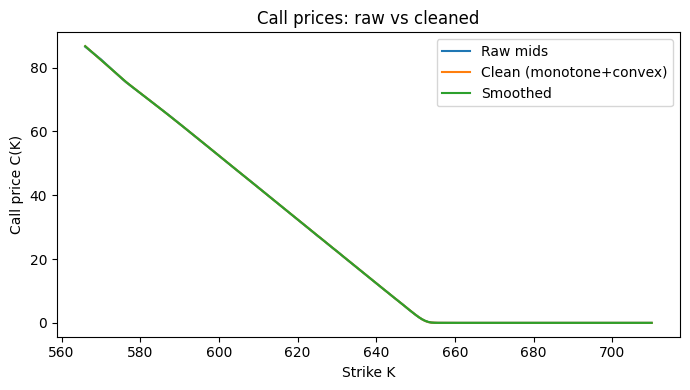

In [8]:
plt.figure(figsize=(7,4))
plt.plot(df_clean['K'], df_clean['C_raw'], label='Raw mids')
plt.plot(df_clean['K'], df_clean['C_clean'], label='Clean (monotone+convex)')
plt.plot(df_clean['K'], df_clean['C_smooth'], label='Smoothed')
plt.xlabel('Strike K')
plt.ylabel('Call price C(K)')
plt.title('Call prices: raw vs cleaned')
plt.legend()
plt.tight_layout()
plt.show()


## 7) First/second derivatives and the implied PDF

We work with **forward‑priced** calls \(C_f(K)=C(K)/D\). Then:
- Tail probability: \(-C_f'(K) \approx \mathbb{Q}(S_T > K)\).
- PDF: \(f_{S_T}(K) = C_f''(K)\).

Because of numerical noise, we **clip** tiny negatives in \(f\) and **renormalize** to integrate to 1.


In [9]:
def central_diff_first(y, x):
    y = np.asarray(y); x = np.asarray(x)
    dy = np.zeros_like(y)
    dy[1:-1] = (y[2:] - y[:-2])/(x[2:] - x[:-2])
    dy[0] = (y[1]-y[0])/(x[1]-x[0])
    dy[-1] = (y[-1]-y[-2])/(x[-1]-x[-2])
    return dy

def central_diff_second(y, x):
    y = np.asarray(y); x = np.asarray(x)
    d2 = np.zeros_like(y)
    # Non-uniform grid safe:
    for i in range(1, len(y)-1):
        h1 = x[i]   - x[i-1]
        h2 = x[i+1] - x[i]
        d2[i] = 2 * ( (y[i+1]-y[i])/h2 - (y[i]-y[i-1])/h1 ) / (h1 + h2)
    d2[0]  = d2[1]
    d2[-1] = d2[-2]
    return d2

C_f = df_clean['C_smooth'].values / max(D, 1e-12)
K   = df_clean['K'].values

C1 = central_diff_first(C_f, K)
C2 = central_diff_second(C_f, K)

f_raw = np.copy(C2)  # risk-neutral pdf before clipping
f_clip = np.clip(f_raw, 0, None)
# Renormalize to integrate to 1
area = np.trapz(f_clip, K)
if area <= 0:
    area = 1.0
f = f_clip / area

# CDF
Fcdf = np.cumsum((f[1:] + f[:-1]) * (K[1:] - K[:-1]) / 2.0)
Fcdf = np.concatenate([[0.0], np.minimum(1.0, Fcdf)])

# Tail prob from first derivative
tail = -C1
tail = np.clip(tail, 0.0, 1.0)


## 8) Diagnostics: mass, mean vs \(F_T\), moments

- Total mass \(\int f = 1\) (after renorm).
- Mean \(\mathbb{E}[S_T] \approx F_T\) (martingale property under \(\mathbb{Q}\)).
- Variance / skew / kurtosis for context.


In [10]:
def moments_from_pdf(K, f):
    # assumes f integrates to 1 on K range
    m1 = np.trapz(K * f, K)
    m2 = np.trapz((K**2) * f, K)
    var = max(0.0, m2 - m1**2)
    std = math.sqrt(var)
    if std <= 1e-12:
        return {'mean':m1, 'var':var, 'std':std, 'skew':np.nan, 'kurt':np.nan}
    m3 = np.trapz(((K - m1)**3) * f, K)
    m4 = np.trapz(((K - m1)**4) * f, K)
    skew = m3 / (std**3)
    kurt = m4 / (std**4)
    return {'mean':m1, 'var':var, 'std':std, 'skew':skew, 'kurt':kurt}

mom = moments_from_pdf(K, f)
mass = np.trapz(f, K)
mean_err = mom['mean'] - F_T

diag = pd.DataFrame({
    'metric': ['pdf mass', 'E[S_T]', 'E[S_T]-F_T', 'Var[S_T]', 'Std[S_T]', 'Skew', 'Kurtosis'],
    'value':  [mass, mom['mean'], mean_err, mom['var'], mom['std'], mom['skew'], mom['kurt']]
})
diag


,metric,value
0,pdf mass,1.000000
1,E[S_T],641.976501
2,E[S_T]-F_T,-10.443429
3,Var[S_T],662.482648
4,Std[S_T],25.738738
5,Skew,-2.087008
6,Kurtosis,5.462857


## 9) Plots: tail probability and PDF

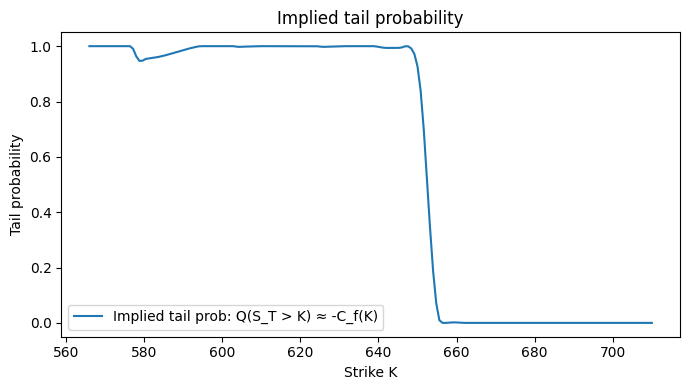

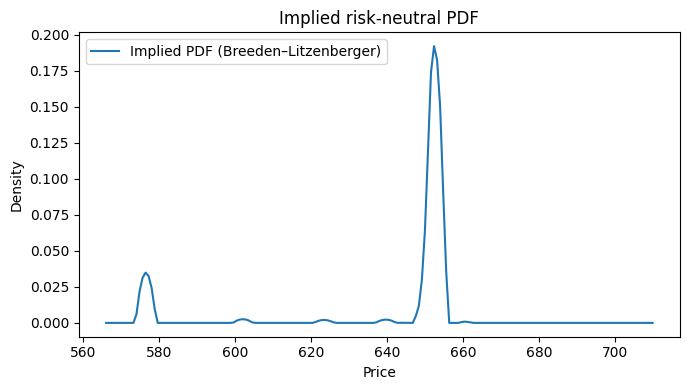

In [13]:
plt.figure(figsize=(7,4))
plt.plot(K, tail, label='Implied tail prob: Q(S_T > K) ≈ -C_f(K)')
plt.xlabel('Strike K')
plt.ylabel('Tail probability')
plt.title('Implied tail probability')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(K, f, label='Implied PDF (Breeden–Litzenberger)')
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Implied risk-neutral PDF')
plt.legend()
plt.tight_layout()
plt.show()


## 10) Optional: overlay a moment-matched lognormal

We fit a lognormal whose mean/variance match the implied ones, to visualize skew/fat tails.


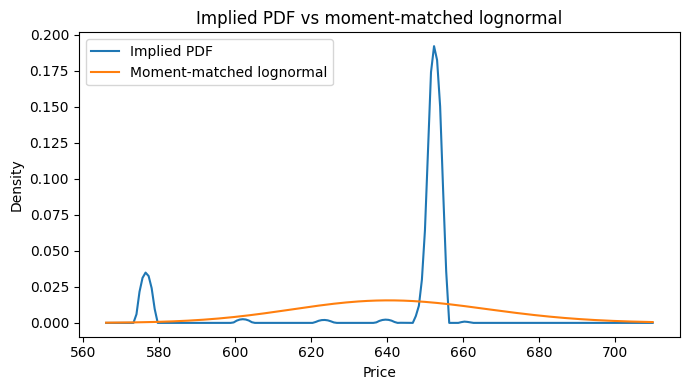

In [12]:
def moment_matched_lognormal(mean, var):
    # Solve for mu, sigma of lognormal such that E[X]=mean, Var[X]=var
    if var <= 0 or mean <= 0:
        return None
    phi2 = var/(mean**2) + 1.0
    sigma2 = math.log(phi2)
    mu = math.log(mean) - 0.5*sigma2
    sigma = math.sqrt(sigma2)
    return mu, sigma

fit = moment_matched_lognormal(mom['mean'], mom['var'])

if fit is not None:
    mu, sig = fit
    from math import sqrt, pi, exp
    def logn_pdf(x):
        x = np.asarray(x)
        with np.errstate(divide='ignore', invalid='ignore'):
            dens = np.exp(-(np.log(x) - mu)**2 / (2*sig**2)) / (x * sig * np.sqrt(2*np.pi))
        dens[~np.isfinite(dens)] = 0.0
        return dens

    f_logn = logn_pdf(K)
    # scale to integrate to 1 on K-range (for overlay fairness)
    f_logn = f_logn / max(1e-12, np.trapz(f_logn, K))
    plt.figure(figsize=(7,4))
    plt.plot(K, f, label='Implied PDF')
    plt.plot(K, f_logn, label='Moment-matched lognormal')
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.title('Implied PDF vs moment-matched lognormal')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Lognormal overlay skipped (nonpositive mean/var)."
)


## 11) Save artifacts (CSV)

We save:
- `cleaned_chain.csv` with `K, C_raw, C_clean, C_smooth`.
- `implied_pdf.csv` with `K, f, tail, cdf`.


In [ ]:
out_clean = pd.DataFrame({'K':K, 'C_raw':df_clean['C_raw'], 'C_clean':df_clean['C_clean'], 'C_smooth':df_clean['C_smooth']})
out_pdf   = pd.DataFrame({'K':K, 'pdf':f, 'tail':tail, 'cdf':np.clip(Fcdf,0,1)})

clean_path = "/mnt/data/cleaned_chain.csv"
pdf_path   = "/mnt/data/implied_pdf.csv"
out_clean.to_csv(clean_path, index=False)
out_pdf.to_csv(pdf_path, index=False)

print("Saved:", clean_path, "and", pdf_path)
